### Packages

In [1]:
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from scipy.sparse import csc_matrix, hstack

import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import f1_score

import gc
import os
import re

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dataexmachina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read data

In [32]:
train = pd.read_csv('../data/dataframe/train.csv')
test = pd.read_csv('../data/dataframe/test.csv')

### Feature extraction

In [3]:
def text_cleaner_words(text):
    
    text = re.sub(r'[^a-zâàäçéèêëîïôùûüœ]+', ' ', text.lower())
    return(text)

def text_cleaner_chars(text):
    
    text = re.sub(r'[^a-zâàäçéèêëîïôùûüœ]+', '', text.lower())
    return(text)

#### word extraction

In [4]:
### english
tf_en = TfidfVectorizer(ngram_range=(1,10), max_features=25000, preprocessor=text_cleaner_words)
tf_en.fit(train[train.type == "english"].text.tolist())
col_en = ['english_%s' % c for c in list(tf_en.vocabulary_)]

### french
tf_fr = TfidfVectorizer(ngram_range=(1,10), max_features=25000, preprocessor=text_cleaner_words)
tf_fr.fit(train[train.type == "french"].text.tolist())
col_fr = ['french_%s' % c for c in list(tf_fr.vocabulary_)]

#### chars extraction

In [5]:
### english
tf_en_char = TfidfVectorizer(ngram_range=(1,1), max_features=100, preprocessor=text_cleaner_chars, analyzer='char')
tf_en_char.fit(train[train.type == "english"].text.tolist())
col_char_en = ['englishChar_%s' % c for c in list(tf_en_char.vocabulary_)]

### french
tf_fr_char = TfidfVectorizer(ngram_range=(1,1), max_features=100, preprocessor=text_cleaner_chars, analyzer='char')
tf_fr_char.fit(train[train.type == "french"].text.tolist())
col_char_fr = ['frenchChar_%s' % c for c in list(tf_fr_char.vocabulary_)]

In [6]:
X = hstack(
    [
        tf_en.transform(train.text.tolist()),
        tf_fr.transform(train.text.tolist()),
        tf_en_char.transform(train.text.tolist()),
        tf_fr_char.transform(train.text.tolist())
    ]
)

y = [1 if x == 'english' else 0 for x in train.type.tolist()]

columns = col_en + col_fr + col_char_en + col_char_fr

Xtest = hstack(
    [
        tf_en.transform(test.text.tolist()),
        tf_fr.transform(test.text.tolist()),
        tf_en_char.transform(test.text.tolist()),
        tf_fr_char.transform(test.text.tolist())
    ]
)

In [7]:
print(X.shape)
gc.collect()

(4692, 50054)


15

### Machine learning

#### Lightgbm

In [8]:
lgbTrain = lgb.Dataset(X, y, feature_name = columns, free_raw_data = True)

In [22]:
params = {'objective': 'binary',
          'learning_rate' : 0.1}

# https://stackoverflow.com/questions/50931168/f1-score-metric-in-lightgbm
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat), True

In [23]:
lgbCv = lgb.cv(params, lgbTrain,
               num_boost_round = 150, stratified = True,
               shuffle = True, nfold = 10, feval = lgb_f1_score, verbose_eval = 5, seed = 2701)

[5]	cv_agg's binary_logloss: 0.455372 + 0.00883722	cv_agg's f1: 0.896134 + 0.0169738
[10]	cv_agg's binary_logloss: 0.349445 + 0.0151151	cv_agg's f1: 0.89648 + 0.0186192
[15]	cv_agg's binary_logloss: 0.29648 + 0.0186907	cv_agg's f1: 0.895625 + 0.0174685
[20]	cv_agg's binary_logloss: 0.266814 + 0.0206733	cv_agg's f1: 0.896555 + 0.0172287
[25]	cv_agg's binary_logloss: 0.250496 + 0.0222768	cv_agg's f1: 0.897405 + 0.0168861
[30]	cv_agg's binary_logloss: 0.240213 + 0.0236342	cv_agg's f1: 0.898973 + 0.0176829
[35]	cv_agg's binary_logloss: 0.23409 + 0.0257822	cv_agg's f1: 0.901149 + 0.0194176
[40]	cv_agg's binary_logloss: 0.229751 + 0.0254825	cv_agg's f1: 0.902397 + 0.0180859
[45]	cv_agg's binary_logloss: 0.228437 + 0.026809	cv_agg's f1: 0.903297 + 0.0168221
[50]	cv_agg's binary_logloss: 0.227544 + 0.0273549	cv_agg's f1: 0.904003 + 0.0175608
[55]	cv_agg's binary_logloss: 0.228262 + 0.0280004	cv_agg's f1: 0.903199 + 0.0165032
[60]	cv_agg's binary_logloss: 0.229077 + 0.0295523	cv_agg's f1: 0.903

In [24]:
bestIter = int(lgbCv['f1-mean'].index(max(lgbCv['f1-mean']))/(1-1/10))
bestIter

138

In [25]:
max(lgbCv['f1-mean'])

0.9071286886986272

In [26]:
lgbModel = lgb.train(params, lgbTrain, num_boost_round = bestIter)

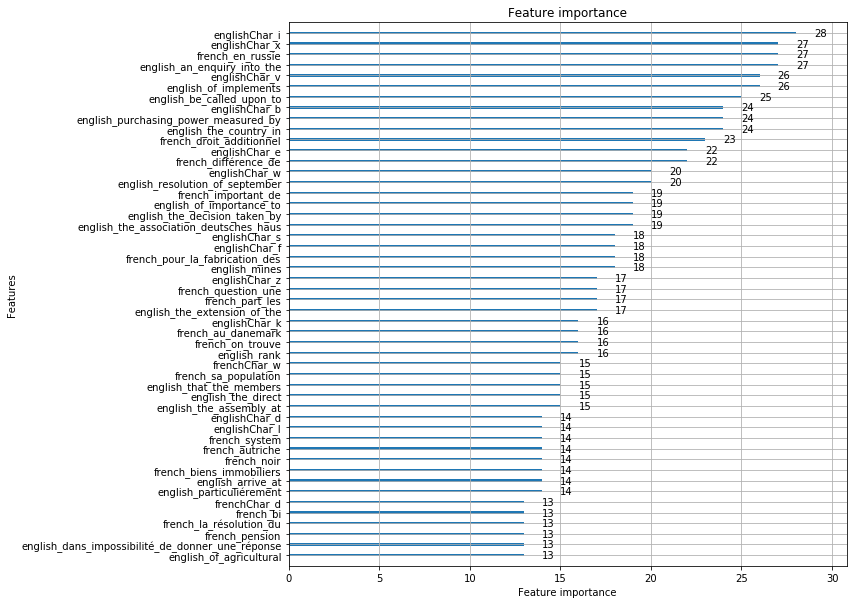

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
lgb.plot_importance(lgbModel, max_num_features = 50, ax = ax)

### Predict and save

In [33]:
test['en'] = lgbModel.predict(Xtest)
test['fr'] = 1 - test['en']

/home/dataexmachina/DataProjects/CrowdAI/ONU_DigitalizationChallenge/crowdai-venv/lib/python3.5/site-packages/lightgbm/basic.py:448: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [34]:
test.head()

,id,text,en,fr
0,56d0687284da6482faaa4a9afede7722,"DLiasus O° NATIONS.\n\nveneva, Mereh 20th, 193...",0.924545,0.075455
1,8e988cca9bab61b6ef4c1ae5b742c5aa,nowonts\n\nNombres-indices par rapport aux chi...,0.997668,0.002332
2,b6e026cc2c57ae5c3cf0dd19ddd607b0,\n\nPEERS.\n\n \n\n \n\nko further l¢zislatio...,0.998614,0.001386
3,e0aff017251bc023e4ff44fd8b701456,"Sea\n\nThe construction of 2,742 houses repres...",0.999755,0.000245
4,5e484277809181c2c873beffffda182c,<p\n\nBudget (continued) -\n\nMonthly (continu...,0.994231,0.005769


In [35]:
test = test[['id', 'en', 'fr']]
test.columns = ['filename', 'en', 'fr']
test['filename'] = list(map(lambda x: x+'.jpg', test.filename.tolist()))

In [36]:
try:
    os.mkdir('../submit')
except: None
    
test.to_csv('../submit/lightgbm_2609.csv', index = False)